# Bridging the Gap Between Purpose and Profit: Analysing the Practice of Impact Investing in Family Offices

### How are philanthrocapitalist investment priorities evolving across geographies, and what does the language of family office reports reveal about the globalisation of purpose-driven finance?

Steps in order how they are written in the academic study:
- EDA (keyword analysis)
- n-gram analysis
- NER
- semantic similarity 

In [92]:
#check that i need all of these packages
import nltk
import string
import PyPDF2
import os
import spacy
import string
import numpy as np
import pandas as pd

nlp = spacy.load('en_core_web_sm')

import matplotlib.pyplot as plt
from collections import Counter, defaultdict

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

from sentence_transformers import SentenceTransformer, util

## Data Preprocessing
### Uploading reports

Loop that goes through each of the reports in my 'reports' folder, turns them into strings, and removes the line breaks.


In [93]:
pdf_folder = 'reports'
pdf_texts = {}

for filename in os.listdir(pdf_folder):
    if filename.endswith('.pdf'):
        report_name = filename.replace('.pdf', '').lower()
        with open(os.path.join(pdf_folder, filename), 'rb') as file:
            reader = PyPDF2.PdfReader(file)
            text = ""
            for page in reader.pages:
                content = page.extract_text()
                if content:
                    text += content + "\n"
            pdf_texts[report_name] = text

In [94]:
ubs24 = pdf_texts['ubs_24']
ubs23 = pdf_texts['ubs_23']
ubs22 = pdf_texts['ubs_22']
pwc24 = pdf_texts['pwc_24']
pwc23 = pdf_texts['pwc_23']
pwc22 = pdf_texts['pwc_22']
citi24 = pdf_texts['citi_24']
citi23 = pdf_texts['citi_23']
citi22 = pdf_texts['citi_22']
campden24 = pdf_texts['campden_24']
campden23 = pdf_texts['campden_23']
campden22 = pdf_texts['campden_22']

### Cleaning the text

Data cleaning done in 2 stages. 
1. Basic cleaning removing punctuation, stop words and non-alphabetic values using the NLP package in SpaCy
2. Tokenisation and lemmatisation of the cleaned data

I created a loop function for each of these that would go through each report.

In [95]:
def clean_text_spacy(text):
    doc = nlp(text)

    cleaned_tokens = [
        token.text.lower() for token in doc if not token.is_punct and not token.is_stop and token.is_alpha
    ]

    cleaned_text = ' '.join(cleaned_tokens)

    return cleaned_text

In [96]:
ubs24_basic = clean_text_spacy(ubs24)
ubs23_basic = clean_text_spacy(ubs23)
ubs22_basic = clean_text_spacy(ubs22)
pwc24_basic = clean_text_spacy(pwc24)
pwc23_basic = clean_text_spacy(pwc23)
pwc22_basic = clean_text_spacy(pwc22)
citi24_basic = clean_text_spacy(citi24)
citi23_basic = clean_text_spacy(citi23)
citi22_basic = clean_text_spacy(citi22)
campden24_basic = clean_text_spacy(campden24)
campden23_basic = clean_text_spacy(campden23)
campden22_basic = clean_text_spacy(campden22)

In [97]:
all_documents = {
    "ubs24": ubs24_basic,
    "ubs23": ubs23_basic,
    "ubs22": ubs22_basic,
    "pwc24": pwc24_basic,
    "pwc23": pwc23_basic,
    "pwc22": pwc22_basic,
    "citi24": citi24_basic,
    "citi23": citi23_basic,
    "citi22": citi22_basic,
    "campden24": campden24_basic,
    "campden23": campden23_basic,
    "campden22": campden22_basic
}

### Tokenising and Lemmatising

In [98]:
def get_word_tokens(text):
    doc = nlp(text)
    tokens = [token.text for token in doc if not token.is_space]
    return tokens

In [99]:
def lemmatize_words(word_tokens):
    lemmatized_words = []
    for word in word_tokens:
        doc = nlp(word)

        lemmatized_word = doc[0].lemma_
        lemmatized_words.append(lemmatized_word)

    return lemmatized_words

In [100]:
ubs24_clean = lemmatize_words(get_word_tokens(ubs24_basic))
ubs23_clean = lemmatize_words(get_word_tokens(ubs23_basic))
ubs22_clean = lemmatize_words(get_word_tokens(ubs22_basic))
pwc24_clean = lemmatize_words(get_word_tokens(pwc24_basic))
pwc23_clean = lemmatize_words(get_word_tokens(pwc23_basic))
pwc22_clean = lemmatize_words(get_word_tokens(pwc22_basic))
citi24_clean = lemmatize_words(get_word_tokens(citi24_basic))
citi23_clean = lemmatize_words(get_word_tokens(citi23_basic))
citi22_clean = lemmatize_words(get_word_tokens(citi22_basic))
campden24_clean = lemmatize_words(get_word_tokens(campden24_basic))
campden23_clean = lemmatize_words(get_word_tokens(campden23_basic))
campden22_clean = lemmatize_words(get_word_tokens(campden22_basic))

In [101]:
years = {
    "2022": ubs22_basic + " " + citi22_basic + " " + pwc22_basic + " " + campden22_basic,
    "2023": ubs23_basic + " " + citi23_basic + " " + pwc23_basic + " " + campden23_basic,
    "2024": ubs24_basic + " " + citi24_basic + " " + pwc24_basic + " " + campden24_basic
}

In [102]:
banks = {
    "ubs": ubs22_basic + " " + ubs23_basic + " " + ubs24_basic,
    "pwc": pwc22_basic + " " + pwc23_basic + " " + pwc24_basic,
    "citi": citi22_basic + " " + citi23_basic + " " + citi24_basic,
    "campden": campden22_basic + " " + campden23_basic + " " + campden24_basic,
}

## Exploratory Data Analysis (EDA)

Analysing word frequencies, keyword frequency, and comparisons across the years of each report, and across banks

In [103]:
reports = {
    'ubs24': ubs24_clean,
    'ubs23': ubs23_clean,
    'ubs22': ubs22_clean,
    'pwc24': pwc24_clean,
    'pwc23': pwc23_clean,
    'pwc22': pwc22_clean,
    'citi24': citi24_clean,
    'citi23': citi23_clean,
    'citi22': citi22_clean,
    'campden24': campden24_clean,
    'campden23': campden23_clean,
    'campden22': campden22_clean,
}

In [104]:
report_frequencies = {name: Counter(tokens) for name, tokens in reports.items()}

#### Top 12 word frequency across all reports:

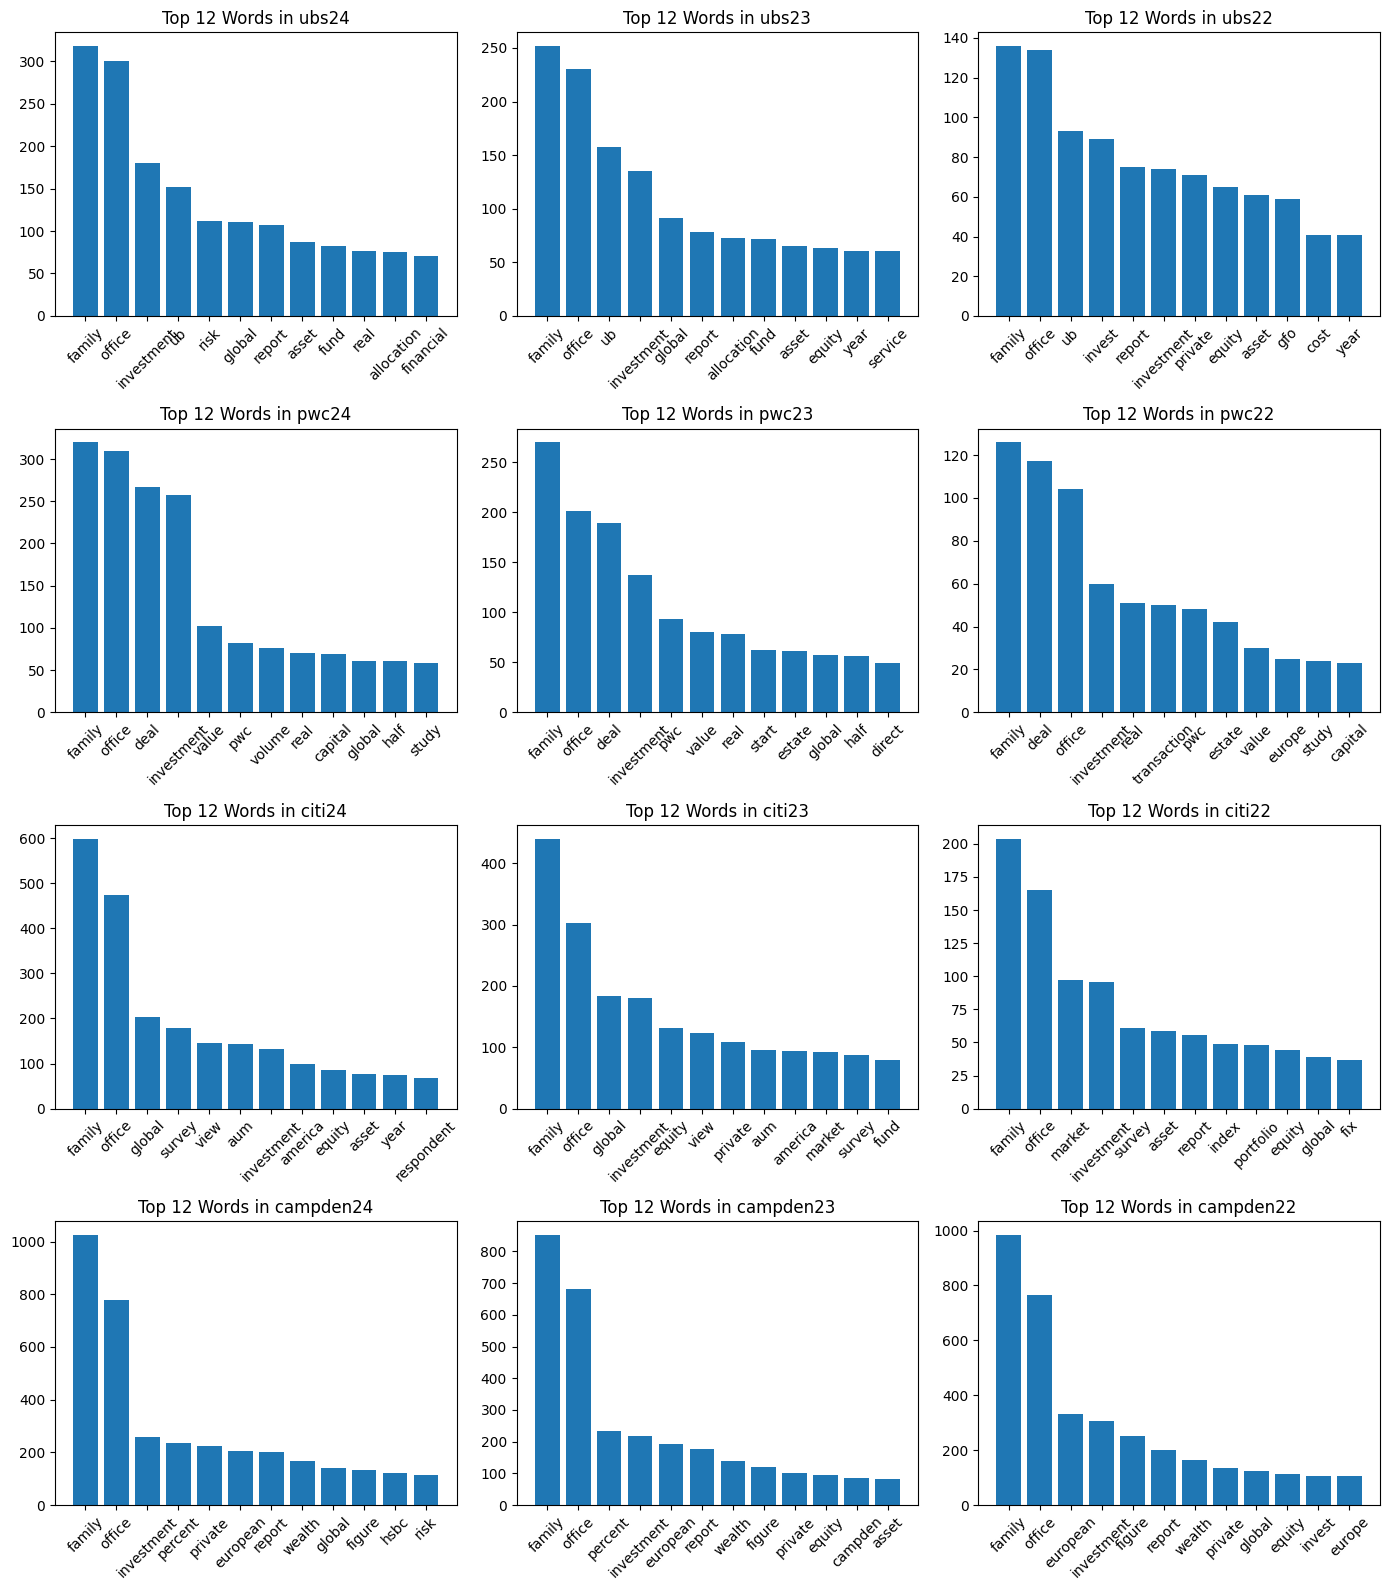

In [105]:
num_reports = len(report_frequencies)
cols = 3
rows = (num_reports + 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(14, rows * 4))
axes = axes.flatten()

plot_idx = 0

for name, freq in report_frequencies.items():
    common = freq.most_common(12)
#    if not common:
#        print(f"⚠️ Skipping {name} - no word frequencies.")
#        continue

    words, counts = zip(*common)
    
    ax = axes[plot_idx]
    ax.bar(words, counts)
    ax.set_title(f"Top 12 Words in {name}")
    ax.tick_params(axis='x', rotation=45)
    
    plot_idx += 1

for i in range(plot_idx, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

#### Keyword frequency across all reports:
- Sustainable
- Impact
- Environment
- Philanthropy
- Climate
- Governance
- ESG

In [106]:
keywords = ['sustainable', 'impact', 'sustainability', 'environmental', 'philanthropy', 'philanthropic', 'climate', 'governance', 'esg']

for name, freq in report_frequencies.items():
    print(f"\n{name}")
    for word in keywords:
        print(f"  {word}: {freq[word]}")


ubs24
  sustainable: 2
  impact: 21
  sustainability: 21
  environmental: 1
  philanthropy: 5
  philanthropic: 1
  climate: 19
  governance: 7
  esg: 1

ubs23
  sustainable: 4
  impact: 4
  sustainability: 1
  environmental: 1
  philanthropy: 2
  philanthropic: 0
  climate: 0
  governance: 9
  esg: 2

ubs22
  sustainable: 17
  impact: 16
  sustainability: 5
  environmental: 2
  philanthropy: 2
  philanthropic: 0
  climate: 3
  governance: 1
  esg: 7

pwc24
  sustainable: 13
  impact: 48
  sustainability: 6
  environmental: 3
  philanthropy: 0
  philanthropic: 0
  climate: 7
  governance: 0
  esg: 4

pwc23
  sustainable: 3
  impact: 3
  sustainability: 1
  environmental: 1
  philanthropy: 0
  philanthropic: 0
  climate: 2
  governance: 2
  esg: 0

pwc22
  sustainable: 0
  impact: 0
  sustainability: 0
  environmental: 0
  philanthropy: 0
  philanthropic: 0
  climate: 0
  governance: 0
  esg: 0

citi24
  sustainable: 19
  impact: 7
  sustainability: 4
  environmental: 8
  philanthropy: 

In [107]:
reports_2022 = ['ubs22', 'pwc22', 'citi22', 'campden22']
reports_2023 = ['ubs23', 'pwc23', 'citi23', 'campden23']
reports_2024 = ['ubs24', 'pwc24', 'citi24', 'campden24']

keywords = ['sustainable', 'impact', 'sustainability', 'environmental', 
            'philanthropy', 'philanthropic', 'climate', 'governance',
            'esg']

def count_keywords(reports, keyword_list):
    counts = {kw: 0 for kw in keyword_list}
    for name in reports:
        freq = report_frequencies.get(name, {})
        for kw in keyword_list:
            counts[kw] += freq.get(kw, 0)
    return counts

counts_2022 = count_keywords(reports_2022, keywords)
counts_2023 = count_keywords(reports_2023, keywords)
counts_2024 = count_keywords(reports_2024, keywords)

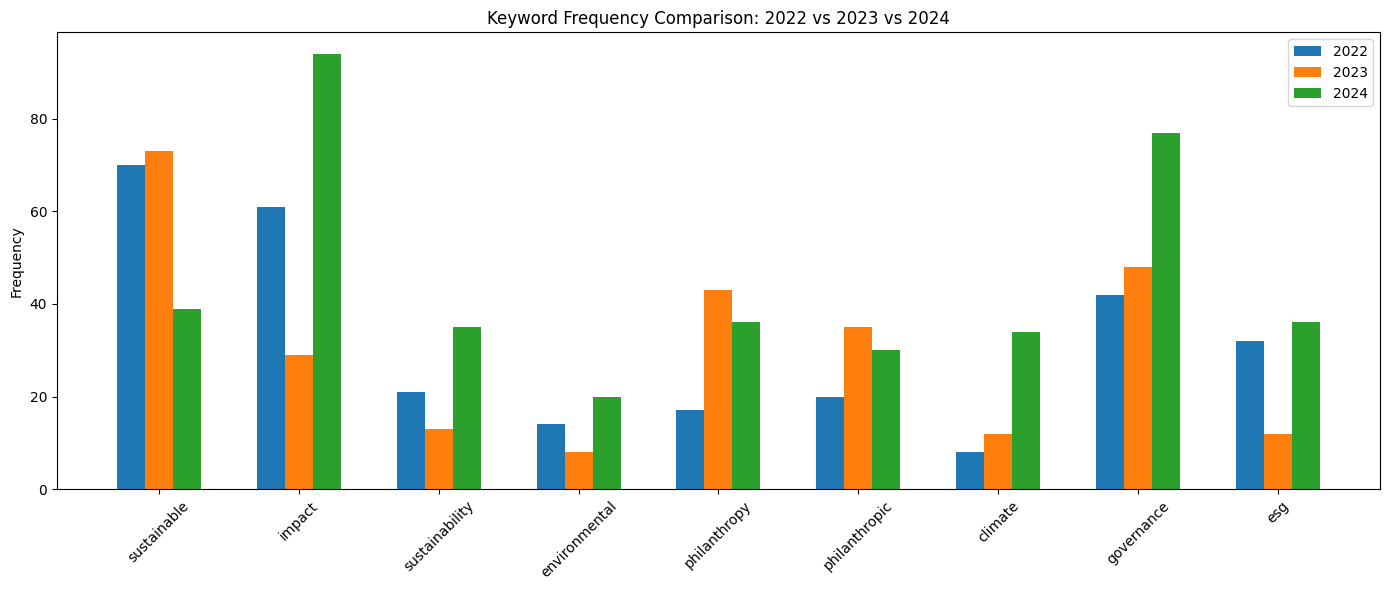

In [108]:
labels = keywords
x = np.arange(len(labels)) * 2  
width = 0.4  

fig, ax = plt.subplots(figsize=(14, 6))
bar1 = ax.bar(x - width, [counts_2022.get(kw, 0) for kw in labels], width, label='2022')
bar2 = ax.bar(x,         [counts_2023.get(kw, 0) for kw in labels], width, label='2023')
bar3 = ax.bar(x + width, [counts_2024.get(kw, 0) for kw in labels], width, label='2024')

# Add labels and formatting
ax.set_ylabel('Frequency')
ax.set_title('Keyword Frequency Comparison: 2022 vs 2023 vs 2024')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

#### Keywords from academic literature 
- Intentionality
- Additionality 
- Attribution
- Contribution 
- Materiality 
- Measurability 
- *Risk*
- Generational

Risk has a very high frequency, so was distorting the graph, therefore I made 2 seperate academic keyword filters, with 2 seperate graphs.

In [109]:
academic_keywords = ['intention', 'addition', 'contribute', 'material', 'advisor', 'measure', 'measurement', 'generation', 'generational']
academic_keywords_risk = ['intention', 'addition', 'contribute', 'material', 'advisor', 'measure', 'measurement', 'generation', 'generational', 'risk']

for name, freq in report_frequencies.items():
    print(f"\n{name}")
    for word in academic_keywords:
        print(f"  {word}: {freq[word]}")


ubs24
  intention: 0
  addition: 0
  contribute: 1
  material: 19
  advisor: 9
  measure: 5
  measurement: 8
  generation: 7
  generational: 9

ubs23
  intention: 0
  addition: 1
  contribute: 1
  material: 7
  advisor: 9
  measure: 1
  measurement: 1
  generation: 4
  generational: 6

ubs22
  intention: 1
  addition: 1
  contribute: 1
  material: 1
  advisor: 5
  measure: 6
  measurement: 0
  generation: 1
  generational: 1

pwc24
  intention: 1
  addition: 1
  contribute: 0
  material: 0
  advisor: 0
  measure: 1
  measurement: 0
  generation: 8
  generational: 2

pwc23
  intention: 0
  addition: 3
  contribute: 1
  material: 0
  advisor: 2
  measure: 1
  measurement: 0
  generation: 4
  generational: 1

pwc22
  intention: 0
  addition: 1
  contribute: 1
  material: 1
  advisor: 1
  measure: 0
  measurement: 0
  generation: 1
  generational: 0

citi24
  intention: 1
  addition: 0
  contribute: 2
  material: 2
  advisor: 3
  measure: 8
  measurement: 0
  generation: 47
  generational

#### Academic keyword frequency excluding *Risk*

In [110]:
def count_keywords(reports, keyword_list):
    counts = {kw: 0 for kw in keyword_list}
    for name in reports:
        freq = report_frequencies.get(name, {})
        for kw in keyword_list:
            counts[kw] += freq.get(kw, 0)
    return counts

counts_2022 = count_keywords(reports_2022, academic_keywords)
counts_2023 = count_keywords(reports_2023, academic_keywords)
counts_2024 = count_keywords(reports_2024, academic_keywords)

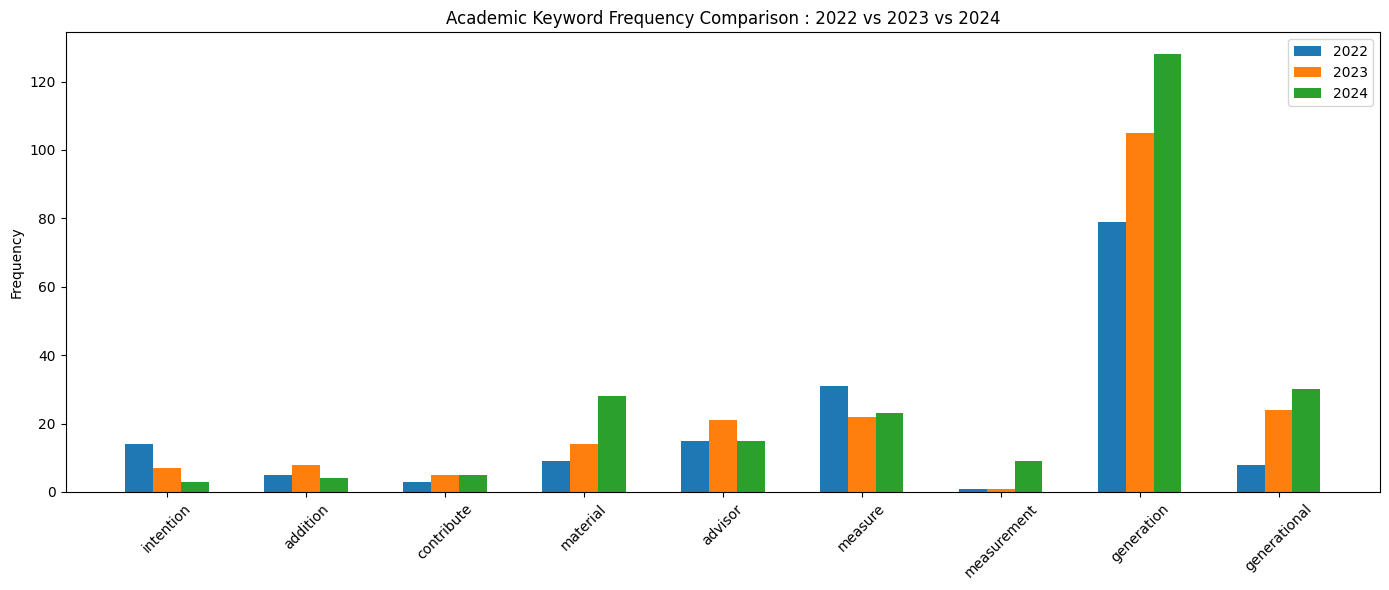

In [111]:
labels = academic_keywords
x = np.arange(len(labels)) * 2  
width = 0.4  

fig, ax = plt.subplots(figsize=(14, 6))
bar1 = ax.bar(x - width, [counts_2022.get(kw, 0) for kw in labels], width, label='2022')
bar2 = ax.bar(x,         [counts_2023.get(kw, 0) for kw in labels], width, label='2023')
bar3 = ax.bar(x + width, [counts_2024.get(kw, 0) for kw in labels], width, label='2024')

# Add labels and formatting
ax.set_ylabel('Frequency')
ax.set_title('Academic Keyword Frequency Comparison : 2022 vs 2023 vs 2024')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

#### Academic keyword frequency including *Risk*

In [112]:
def count_keywords(reports, keyword_list):
    counts = {kw: 0 for kw in keyword_list}
    for name in reports:
        freq = report_frequencies.get(name, {})
        for kw in keyword_list:
            counts[kw] += freq.get(kw, 0)
    return counts

counts_2022 = count_keywords(reports_2022, academic_keywords_risk)
counts_2023 = count_keywords(reports_2023, academic_keywords_risk)
counts_2024 = count_keywords(reports_2024, academic_keywords_risk)

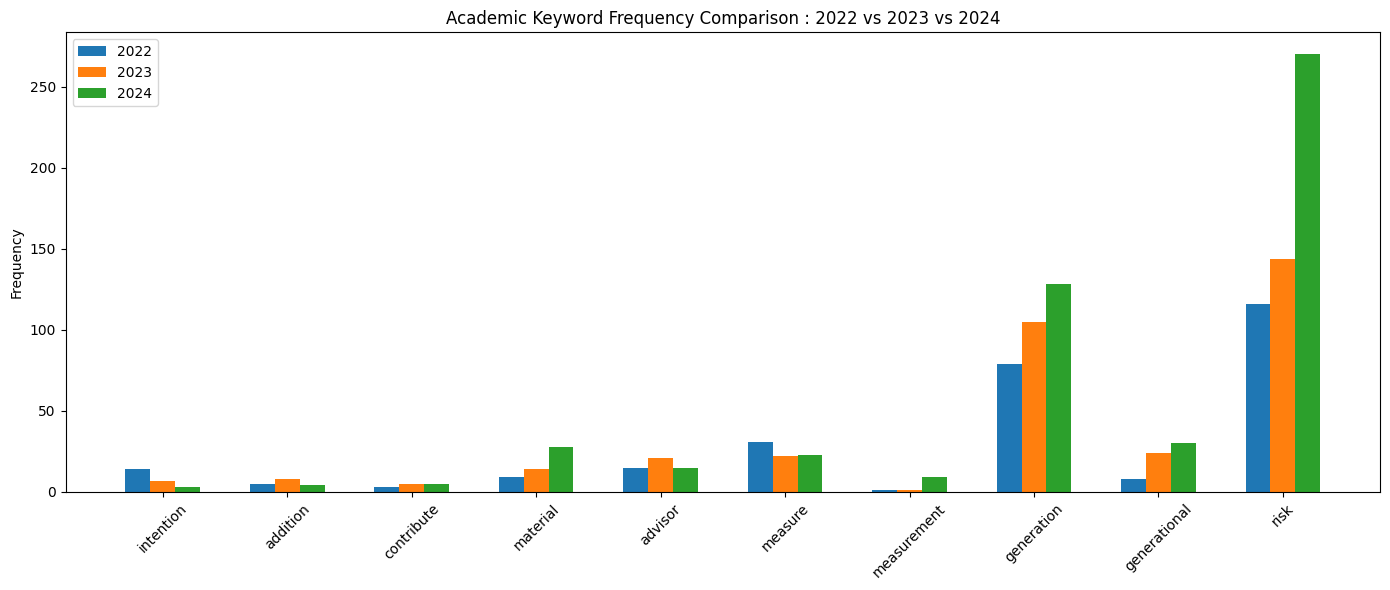

In [113]:
labels = academic_keywords_risk
x = np.arange(len(labels)) * 2  
width = 0.4  

fig, ax = plt.subplots(figsize=(14, 6))
bar1 = ax.bar(x - width, [counts_2022.get(kw, 0) for kw in labels], width, label='2022')
bar2 = ax.bar(x,         [counts_2023.get(kw, 0) for kw in labels], width, label='2023')
bar3 = ax.bar(x + width, [counts_2024.get(kw, 0) for kw in labels], width, label='2024')

# Add labels and formatting
ax.set_ylabel('Frequency')
ax.set_title('Academic Keyword Frequency Comparison : 2022 vs 2023 vs 2024')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

## N-Gram Analysis

N-Gram analysis looks at the breakdown of words 2-gram (bigram) or 3-gram (trigram) in this case, and the freqyency of them. This is key to analyze patterns and relationships within data.

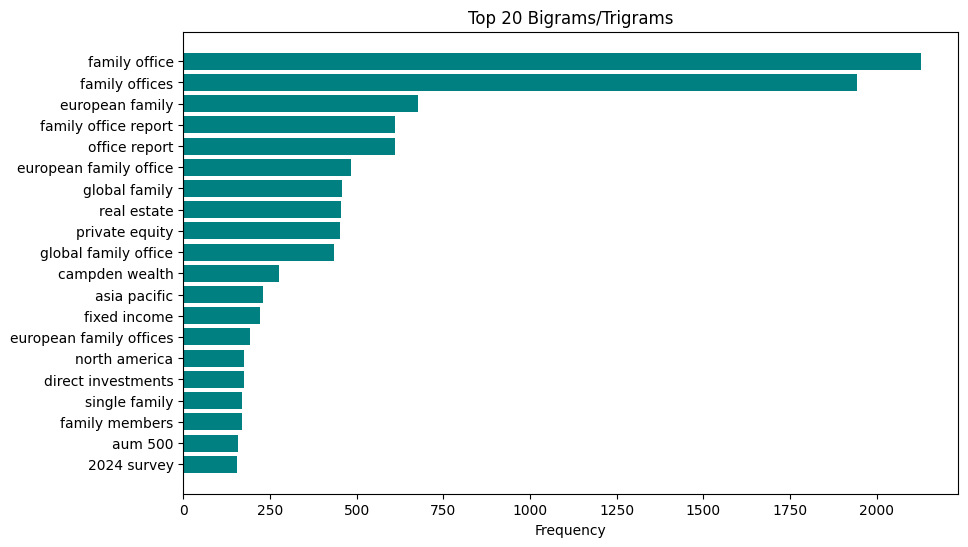

                          ngram  count
63993             family office   2128
64396            family offices   1944
59969           european family    677
64297      family office report    611
102040            office report    611
59970    european family office    483
72288             global family    458
119751              real estate    455
115686           private equity    453
72292      global family office    436
37537            campden wealth    277
30290              asia pacific    230
67720              fixed income    222
59971   european family offices    192
99811             north america    176
52287        direct investments    175
133219            single family    170
63814            family members    170
31909                   aum 500    158
8420                2024 survey    154


In [114]:
documents = [ubs24, ubs23, ubs22, pwc24, pwc23, pwc22, citi24, citi23, citi22, campden24, campden23, campden22]

vectorizer = CountVectorizer(ngram_range=(2, 3), stop_words='english')
X = vectorizer.fit_transform(documents)

ngrams = vectorizer.get_feature_names_out()
counts = X.toarray().sum(axis=0)

ngram_freq = pd.DataFrame({'ngram': ngrams, 'count': counts})
ngram_freq = ngram_freq.sort_values(by='count', ascending=False)

top_ngrams = ngram_freq.head(20)

plt.figure(figsize=(10, 6))
plt.barh(top_ngrams['ngram'], top_ngrams['count'], color='teal')
plt.xlabel('Frequency')
plt.title('Top 20 Bigrams/Trigrams')
plt.gca().invert_yaxis() 
plt.show()
print(ngram_freq.head(20))

#### N-Gram analysis on Keywords
- Impact
- Sustainable
- Philanthropy
- Climate

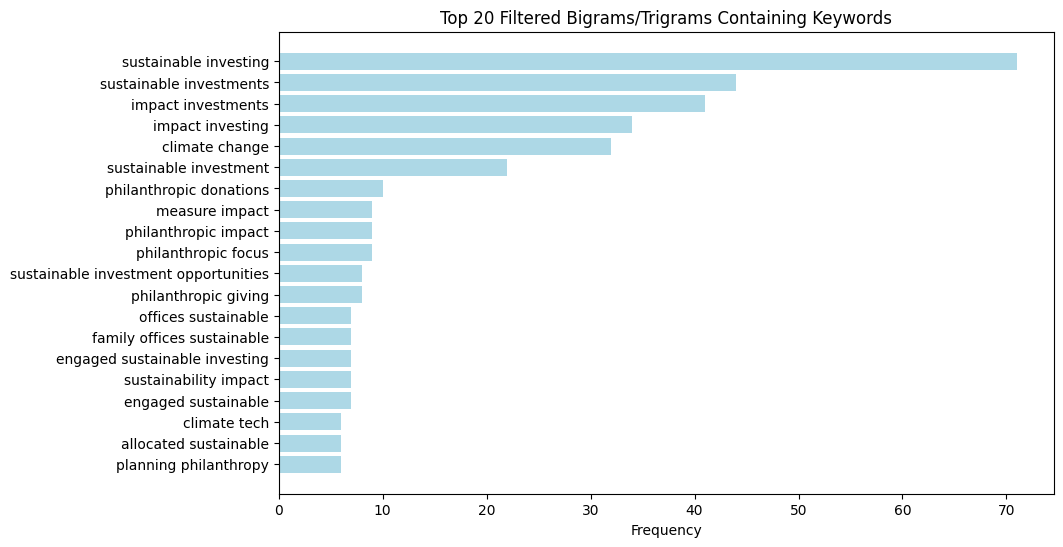

                                       ngram  count
139458                 sustainable investing     71
139523               sustainable investments     44
77721                     impact investments     41
77683                       impact investing     34
41514                         climate change     32
139513                sustainable investment     22
110970               philanthropic donations     10
95410                         measure impact      9
111022                  philanthropic impact      9
110996                   philanthropic focus      9
139518  sustainable investment opportunities      8
111012                  philanthropic giving      8
104837                   offices sustainable      7
65072             family offices sustainable      7
56718          engaged sustainable investing      7
139358                 sustainability impact      7
56717                    engaged sustainable      7
41562                           climate tech      6
27154       

In [115]:
keywords = ['impact', 'sustainable', 'sustainability', 'philanthropy', 'philanthropic', 'climate']
filtered_ngrams = ngram_freq[ngram_freq['ngram'].str.contains('|'.join(keywords))]

top_20_filtered_ngrams = filtered_ngrams.head(20)

plt.figure(figsize=(10, 6))
plt.barh(top_20_filtered_ngrams['ngram'], top_20_filtered_ngrams['count'], color='lightblue')
plt.xlabel('Frequency')
plt.title('Top 20 Filtered Bigrams/Trigrams Containing Keywords')
plt.gca().invert_yaxis()  # To display the highest counts at the top
plt.show()
print(top_20_filtered_ngrams)

#### N-Gram analysis on academic keywords
- Intention
- Addition
- Contribute
- Material
- Washing
- Generational
- Risk

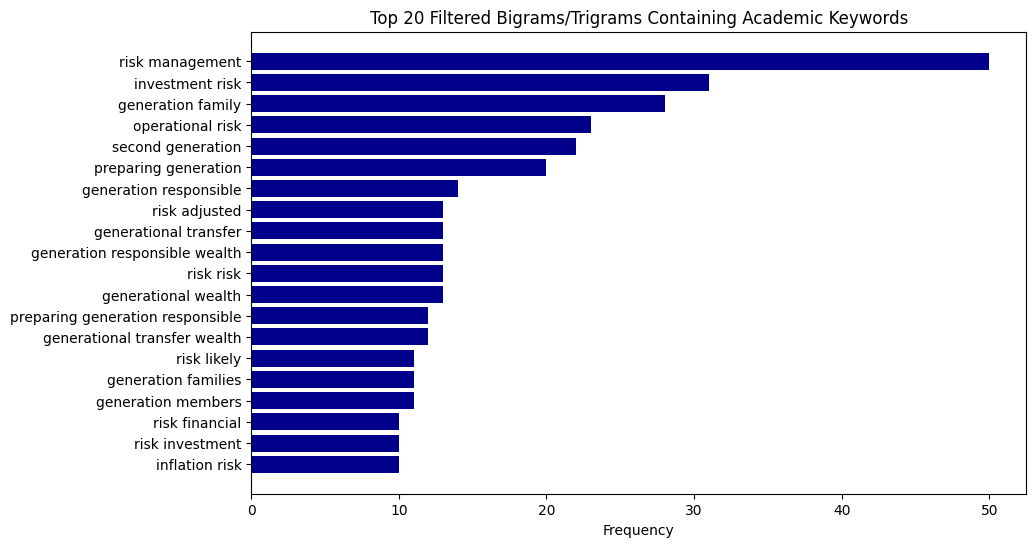

                                   ngram  count
127808                   risk management     50
84538                    investment risk     31
70984                  generation family     28
105747                  operational risk     23
129625                 second generation     22
114648              preparing generation     20
71120             generation responsible     14
127517                     risk adjusted     13
71207              generational transfer     13
71122      generation responsible wealth     13
127932                         risk risk     13
71226                generational wealth     13
114655  preparing generation responsible     12
71209       generational transfer wealth     12
127781                       risk likely     11
70973                generation families     11
71059                 generation members     11
127694                    risk financial     10
127768                   risk investment     10
80523                     inflation risk

In [116]:
academic_keywords = ['intention', 'addition', 'contribute', 'material', 'washing', 'generation', 'generational', 'risk']
filtered_ngrams = ngram_freq[ngram_freq['ngram'].str.contains('|'.join(academic_keywords))]

top_20_filtered_ngrams = filtered_ngrams.head(20)

plt.figure(figsize=(10, 6))
plt.barh(top_20_filtered_ngrams['ngram'], top_20_filtered_ngrams['count'], color='darkblue')
plt.xlabel('Frequency')
plt.title('Top 20 Filtered Bigrams/Trigrams Containing Academic Keywords')
plt.gca().invert_yaxis()
plt.show()
print(top_20_filtered_ngrams)

## Named Entity Recogntion (NER)

NER is used ot identify and classify key information (entities) in text into predefined categories such as:

- "ORG" - for organisations, locations and people

- "GPE" - for countries, cities and states

- "PERSON" - for people

- "DATE" - for time related entities

- "MONEY" - for monetary values

In [117]:
type(years)

dict

In [118]:
ENTITY_TYPE = "GPE"  

entity_counts_by_year = defaultdict(Counter)

# Loop through years and texts
for year, text in years.items():
    doc = nlp(text)  # Run NLP processing
    entities = [ent.text for ent in doc.ents if ent.label_ == ENTITY_TYPE]
    top_entities = Counter(entities).most_common(10)
    for entity, count in top_entities:
        entity_counts_by_year[year][entity] = count

df = pd.DataFrame(entity_counts_by_year).fillna(0).astype(int)
df = df.T

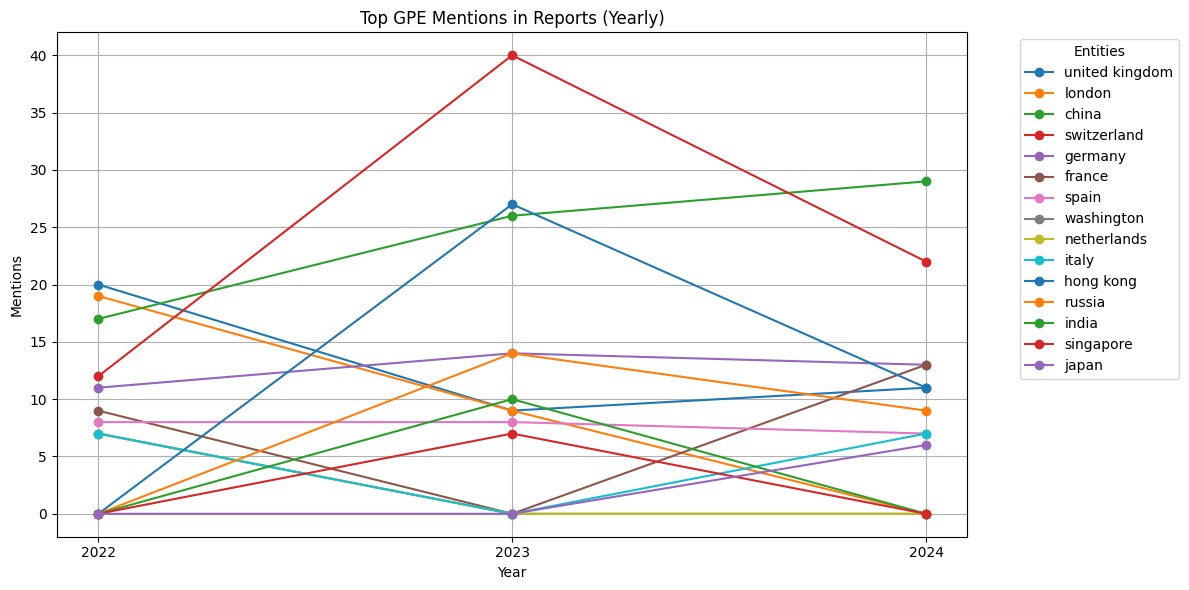

In [119]:
plt.figure(figsize=(12, 6))

for entity in df.columns:
    plt.plot(df.index, df[entity], label=entity, marker='o')

plt.title(f"Top {ENTITY_TYPE} Mentions in Reports (Yearly)")
plt.xlabel("Year")
plt.ylabel("Mentions")
plt.legend(title="Entities", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()

In [120]:
ENTITY_TYPE = "GPE"  
top_n = 5  

entity_counts_by_bank = {}

for bank, text in banks.items():
    doc = nlp(text)
    entities = [ent.text for ent in doc.ents if ent.label_ == ENTITY_TYPE]
    top_entities = Counter(entities).most_common(top_n)
    entity_counts_by_bank[bank] = top_entities


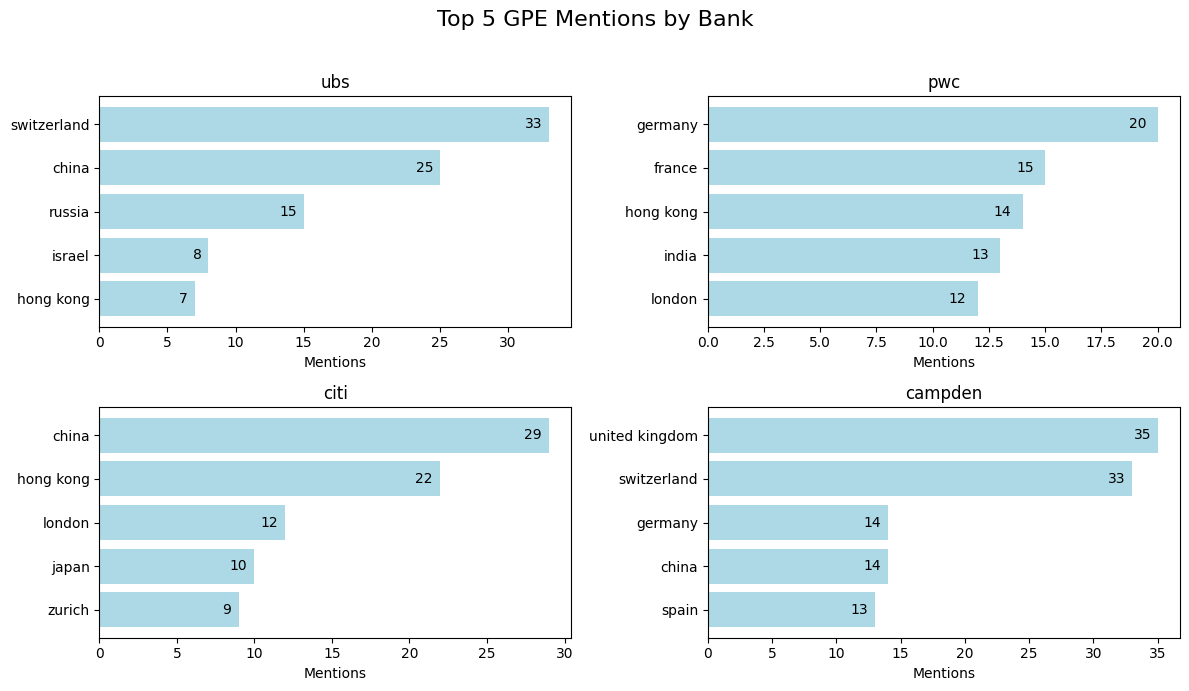

In [121]:
num_banks = len(entity_counts_by_bank)
cols = 2
rows = (num_banks + 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 3.5))
axes = axes.flatten()

for idx, (bank, entities) in enumerate(entity_counts_by_bank.items()):
    labels, counts = zip(*entities)
    axes[idx].barh(labels, counts, color='lightblue')
    axes[idx].invert_yaxis()  # Highest count on top
    axes[idx].set_title(bank)
    axes[idx].set_xlabel("Mentions")
    for i, (label, count) in enumerate(zip(labels, counts)):
        axes[idx].text(count - 0.5, i, str(count), va='center', ha='right', fontsize=10)

fig.suptitle(f"Top {top_n} {ENTITY_TYPE} Mentions by Bank", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [122]:
all_text = ' '.join(all_documents)

ENTITY_TYPE = "GPE"  # Change as needed

entities = [ent.text for ent in doc.ents if ent.label_ == ENTITY_TYPE]

top_entities = Counter(entities).most_common(10)
print(f"\nTop {ENTITY_TYPE} entities in all documents:")
for entity, count in top_entities:
    print(f"  {entity}: {count}")


Top GPE entities in all documents:
  united kingdom: 35
  switzerland: 33
  germany: 14
  china: 14
  spain: 13
  london: 8
  luxembourg: 6
  france: 6
  italy: 5
  kingdom: 5


## Semantic Similarity Modelling

Semantic similarity analysis helps identify how closely related different texts are in meaning, even if they use different language. It reveals how consistently family offices and financial institutions articulate themes like impact, purpose, or philanthropy across years and geographies.

#### Impact Keyword Semantic Similarity

In [123]:
# Initialize model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Your yearly documents
year_texts = list(years.values())
years_list = list(years.keys())

# Encode year documents
year_embeddings = model.encode(year_texts, convert_to_tensor=True)

# Define your concept phrase(s)
concepts = ['sustainable', 'impact', 'sustainability', 'environmental', 'philanthropy', 'philanthropic', 'climate', 'governance']
concept_embeddings = model.encode(concepts, convert_to_tensor=True)

# Calculate similarity
similarities = util.cos_sim(concept_embeddings, year_embeddings)

# Display results
import pandas as pd
sim_df = pd.DataFrame(similarities.cpu().numpy(), index=concepts, columns=years_list)
print(sim_df.round(3))


                 2022   2023   2024
sustainable     0.194  0.129  0.158
impact          0.099  0.066  0.089
sustainability  0.218  0.134  0.171
environmental   0.055  0.076  0.095
philanthropy    0.222  0.164  0.121
philanthropic   0.248  0.198  0.149
climate         0.040  0.057  0.136
governance      0.184  0.131  0.148


#### Academic Keyword Semantic Similarity

Looking at whether the keywords found in the academic literature are related to the corpus of reports

In [124]:
concepts_2 = ['intention', 'addition', 'contribute', 'material', 'advisor', 'measure', 'generation', 'generational']

concept_embeddings = model.encode(concepts_2, convert_to_tensor=True)

# Calculate similarity
similarities = util.cos_sim(concept_embeddings, year_embeddings)

# Display results
import pandas as pd
sim_df = pd.DataFrame(similarities.cpu().numpy(), index=concepts_2, columns=years_list)
print(sim_df.round(3))

               2022   2023   2024
intention    -0.007  0.007 -0.066
addition      0.047  0.025  0.020
contribute    0.136  0.111  0.069
material     -0.032 -0.000 -0.054
advisor       0.203  0.224  0.147
measure       0.031  0.038  0.016
generation    0.070  0.105  0.071
generational  0.050  0.104  0.051
